### Notebook for the epithelial label transfer of Reference mesenchymal dataset to rest of mesenchymal cells from GCA using `scANVI`

- **Developed by:** Anna Maguza
- **Institute of Computational Biology - Computational Health Department - Helmholtz Munich**
- 27th February 2022

### Import required modules

In [1]:
import scvi
import anndata
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

/Users/anna.maguza/miniconda3/envs/scvi_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 0
/Users/anna.maguza/miniconda3/envs/scvi_env/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/anna.maguza/miniconda3/envs/scvi_env/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/anna.maguza/miniconda3/envs/scvi_env/lib/python3.9/site-packages/flax/struct.py:132: FutureWarnin

### Set up working environment

In [2]:
%matplotlib inline

In [3]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.8.0
scanpy      1.9.3
-----
PIL                         9.4.0
absl                        NA
appnope                     0.1.2
asttokens                   NA
attr                        22.2.0
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
brotli                      NA
certifi                     2022.12.07
cffi                        1.15.1
charset_normalizer          2.1.1
chex                        0.1.6
colorama                    0.4.6
comm                        0.1.2
contextlib2                 NA
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml                  0.7.1
docrep                      0.3.2
entrypoints                 0.4
executing                   0.8.3
flax                        0.6.1
fsspec                      2023.3.0
h5py                        3.8.0
hypergeom_uf

In [4]:
warnings.simplefilter(action = 'ignore')
scvi.settings.seed = 1712
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'

Global seed set to 1712


In [5]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 2,
)

### Read in Reference object

In [ ]:
#Cluster path
reference_input = '/lustre/groups/talaveralopez/workspace/anna.maguza/Processed_datasets/expi_map/Mesenchymal_reference_map_subset_after_geosketch2.h5ad'
reference_output = '/lustre/groups/talaveralopez/workspace/anna.maguza/Processed_datasets/expi_map/Mesenchymal_reference_map_subset_after_geosketch2_output.h5ad'

In [6]:
#Local machine path
reference_input = '/Users/anna.maguza/Desktop/Data/Processed_datasets/Geosketch_subsets/Mesenchymal_cells/Mesenchymal_reference_map_subset_after_geosketch.h5ad'
reference_output = '/Users/anna.maguza/Desktop/Data/Processed_datasets/Geosketch_subsets/Mesenchymal_cells/Mesenchymal_reference_map_subset_after_geosketch2_output.h5ad'

In [7]:
reference = sc.read_h5ad(reference_input)
reference.X

<107299x40144 sparse matrix of type '<class 'numpy.float32'>'
	with 218803365 stored elements in Compressed Sparse Row format>

In [8]:
reference.obs

UniqueCell_ID  \
cell_id                                                                  
AACACGTTCTTGCATT_Ileum-1_Stem Cell  AACACGTTCTTGCATT_Ileum-1_Stem Cell   
AACCGCGCATGAAGTA_Ileum-1_Stem Cell  AACCGCGCATGAAGTA_Ileum-1_Stem Cell   
AACTCAGAGCGATCCC_Ileum-1_Stem Cell  AACTCAGAGCGATCCC_Ileum-1_Stem Cell   
AACTCCCTCTCAACTT_Ileum-1_Stem Cell  AACTCCCTCTCAACTT_Ileum-1_Stem Cell   
AACTCTTAGCTTCGCG_Ileum-1_Stem Cell  AACTCTTAGCTTCGCG_Ileum-1_Stem Cell   
...                                                                ...   
TGACGGCTCCGTTGCT-1-4918STDY7718976                                 nan   
TTAGTTCGTGTGGTTT-1-4918STDY7718976                                 nan   
TTCCCAGGTGCGATAG-1-4918STDY7718976                                 nan   
TTGCCGTTCCCAACGG-1-4918STDY7718976                                 nan   
AAGCCGCTCAACTCTT-1-4918STDY7718977                                 nan   

                                   Sample_ID     CellType      Study_name  \
cell_id                                                                     
AACACGTTCTTGCATT_Ileum-1_Stem Cell   Ileum-1    Stem Cell            Wang   
AACCGCGCATGAAGTA_Ileum-1_Stem Cell   Ileum-1    Stem Cell            Wang   
AACTCAGAGCGATCCC_Ileum-1_Stem Cell   Ileum-1    Stem Cell            Wang   
AACTCCCTCTCAACTT_Ileum-1_Stem Cell   Ileum-1    Stem Cell            Wang   
AACTCTTAGCTTCGCG_Ileum-1_Stem Cell   Ileum-1    Stem Cell            Wang   
...                                      ...          ...             ...   
TGACGGCTCCGTTGCT-1-4918STDY7718976       nan  Mesenchymal  Gut Cell Atlas   
TTAGTTCGTGTGGTTT-1-4918STDY7718976       nan  Mesenchymal  Gut Cell Atlas   
TTCCCAGGTGCGATAG-1-4918STDY7718976       nan  Mesenchymal  Gut Cell Atlas   
TTGCCGTTCCCAACGG-1-4918STDY7718976       nan  Mesenchymal  Gut Cell Atlas   
AAGCCGCTCAACTCTT-1-4918STDY7718977       nan  Mesenchymal  Gut Cell Atlas   

                                        Donor_ID      Diagnosis   Age  \
cell_id                                                                 
AACACGTTCTTGCATT_Ileum-1_Stem Cell  Wang_Donor_1  Healthy adult   nan   
AACCGCGCATGAAGTA_Ileum-1_Stem Cell  Wang_Donor_1  Healthy adult   nan   
AACTCAGAGCGATCCC_Ileum-1_Stem Cell  Wang_Donor_1  Healthy adult   nan   
AACTCCCTCTCAACTT_Ileum-1_Stem Cell  Wang_Donor_1  Healthy adult   nan   
AACTCTTAGCTTCGCG_Ileum-1_Stem Cell  Wang_Donor_1  Healthy adult   nan   
...                                          ...            ...   ...   
TGACGGCTCCGTTGCT-1-4918STDY7718976       BRC2134          fetal  10Wk   
TTAGTTCGTGTGGTTT-1-4918STDY7718976       BRC2134          fetal  10Wk   
TTCCCAGGTGCGATAG-1-4918STDY7718976       BRC2134          fetal  10Wk   
TTGCCGTTCCCAACGG-1-4918STDY7718976       BRC2134          fetal  10Wk   
AAGCCGCTCAACTCTT-1-4918STDY7718977       BRC2134          fetal  10Wk   

                                   Region code   Fraction Gender  ...  \
cell_id                                                           ...   
AACACGTTCTTGCATT_Ileum-1_Stem Cell         nan        nan    nan  ...   
AACCGCGCATGAAGTA_Ileum-1_Stem Cell         nan        nan    nan  ...   
AACTCAGAGCGATCCC_Ileum-1_Stem Cell         nan        nan    nan  ...   
AACTCCCTCTCAACTT_Ileum-1_Stem Cell         nan        nan    nan  ...   
AACTCTTAGCTTCGCG_Ileum-1_Stem Cell         nan        nan    nan  ...   
...                                        ...        ...    ...  ...   
TGACGGCTCCGTTGCT-1-4918STDY7718976        FTIL  SC-EPCAMP      M  ...   
TTAGTTCGTGTGGTTT-1-4918STDY7718976        FTIL  SC-EPCAMP      M  ...   
TTCCCAGGTGCGATAG-1-4918STDY7718976        FTIL  SC-EPCAMP      M  ...   
TTGCCGTTCCCAACGG-1-4918STDY7718976        FTIL  SC-EPCAMP      M  ...   
AAGCCGCTCAACTCTT-1-4918STDY7718977         FLI  SC-EPCAMP      M  ...   

                                   total_counts_mt        doublet_scores  \
cell_id                                                                    
AACACGTTCTTGCATT_Ileum-1_Stem Cell      

In [9]:
reference.obs['seed_labels'] = reference.obs['Cell States'].copy()

### Read query object

In [10]:
query_input = '/Users/anna.maguza/Desktop/Data/Processed_datasets/Geosketch_subsets/Mesenchymal_cells/Mesenchymal_query_map_after_geosketch.h5ad'
query_output = '/Users/anna.maguza/Desktop/Data/Processed_datasets/Geosketch_subsets/Mesenchymal_cells/Mesenchymal_query_map_after_geosketch2_output.h5ad'

In [11]:
query = sc.read_h5ad(query_input)
query.X

<50994x40144 sparse matrix of type '<class 'numpy.float32'>'
	with 76872017 stored elements in Compressed Sparse Row format>

In [12]:
query.obs['seed_labels'] = 'Unknown'

In [13]:
# Concatenate reference and query
adata = reference.concatenate(query, batch_key = 'dataset', batch_categories = ['reference', 'query'])

### Select HVGs

In [14]:
adata_raw = adata.copy()

In [15]:
sc.pp.log1p(adata)

In [16]:
adata.layers['counts'] = adata.X.copy()

In [17]:
adata.obs_keys

<bound method AnnData.obs_keys of AnnData object with n_obs × n_vars = 158293 × 40144
    obs: 'UniqueCell_ID', 'Sample_ID', 'CellType', 'Study_name', 'Donor_ID', 'Diagnosis', 'Age', 'Region code', 'Fraction', 'Gender', '10X', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts_mt', 'doublet_scores', 'predicted_doublets', 'Age_group', 'total_counts_ribo', 'Location', 'n_counts', 'percent_mito', 'percent_ribo', 'Cell States', 'seed_labels', 'dataset'
    uns: 'log1p'
    layers: 'counts'>

In [18]:
adata.obs['Donor_ID'].value_counts()

BRC2258    25508
F73        19037
BRC2133    14680
BRC2134    11051
F66        10438
           ...  
N539           9
N106           9
N44            8
N49            4
N12            3
Name: Donor_ID, Length: 65, dtype: int64

In [19]:
sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 3000,
    layer = "counts",
    batch_key = "Donor_ID",
    subset = True,
    span = 1
)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


### Transfer of annotation with scANVI

In [20]:
scvi.model.SCVI.setup_anndata(adata, batch_key = 'Donor_ID', labels_key = "seed_labels", layer = 'counts')

In [21]:
scvi_model = scvi.model.SCVI(adata, n_latent = 50, n_layers = 3, dispersion = 'gene-batch', gene_likelihood = 'nb')

In [22]:
scvi_model.train(150)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 150/150: 100%|██████████| 150/150 [2:10:10<00:00, 51.87s/it, loss=356, v_num=1]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 150/150: 100%|██████████| 150/150 [2:10:10<00:00, 52.07s/it, loss=356, v_num=1]


### Label transfer with `scANVI` 

In [23]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')

In [24]:
scanvi_model.train(50)

INFO     Training for 50 epochs.                                                                                   


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 50/50: 100%|██████████| 50/50 [2:19:43<00:00, 168.78s/it, loss=470, v_num=1]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [2:19:43<00:00, 167.67s/it, loss=470, v_num=1]


In [25]:
adata.obs["C_scANVI"] = scanvi_model.predict(adata)

- Extract latent representation

In [26]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

- Visualise corrected dataset

In [27]:
sc.pp.neighbors(adata, use_rep = "X_scANVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.2, spread = 2, random_state = 1712)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:35)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:39)


In [28]:
adata.obs

UniqueCell_ID  \
cell_id                                                                            
AACACGTTCTTGCATT_Ileum-1_Stem Cell-reference  AACACGTTCTTGCATT_Ileum-1_Stem Cell   
AACCGCGCATGAAGTA_Ileum-1_Stem Cell-reference  AACCGCGCATGAAGTA_Ileum-1_Stem Cell   
AACTCAGAGCGATCCC_Ileum-1_Stem Cell-reference  AACTCAGAGCGATCCC_Ileum-1_Stem Cell   
AACTCCCTCTCAACTT_Ileum-1_Stem Cell-reference  AACTCCCTCTCAACTT_Ileum-1_Stem Cell   
AACTCTTAGCTTCGCG_Ileum-1_Stem Cell-reference  AACTCTTAGCTTCGCG_Ileum-1_Stem Cell   
...                                                                          ...   
TTTGGTTGTTCCACTC-1-4918STDY7718977-query                                     nan   
TTTGTCAAGATCCCAT-1-4918STDY7718977-query                                     nan   
TTTGTCATCCATGCTC-1-4918STDY7718977-query                                     nan   
TTTGTCATCCCAAGTA-1-4918STDY7718977-query                                     nan   
TTTGTCATCCGTAGTA-1-4918STDY7718977-query                                     nan   

                                             Sample_ID     CellType  \
cell_id                                                               
AACACGTTCTTGCATT_Ileum-1_Stem Cell-reference   Ileum-1    Stem Cell   
AACCGCGCATGAAGTA_Ileum-1_Stem Cell-reference   Ileum-1    Stem Cell   
AACTCAGAGCGATCCC_Ileum-1_Stem Cell-reference   Ileum-1    Stem Cell   
AACTCCCTCTCAACTT_Ileum-1_Stem Cell-reference   Ileum-1    Stem Cell   
AACTCTTAGCTTCGCG_Ileum-1_Stem Cell-reference   Ileum-1    Stem Cell   
...                                                ...          ...   
TTTGGTTGTTCCACTC-1-4918STDY7718977-query           nan  Mesenchymal   
TTTGTCAAGATCCCAT-1-4918STDY7718977-query           nan  Mesenchymal   
TTTGTCATCCATGCTC-1-4918STDY7718977-query           nan  Mesenchymal   
TTTGTCATCCCAAGTA-1-4918STDY7718977-query           nan  Mesenchymal   
TTTGTCATCCGTAGTA-1-4918STDY7718977-query           nan  Mesenchymal   

                                                  Study_name      Donor_ID  \
cell_id                                                                      
AACACGTTCTTGCATT_Ileum-1_Stem Cell-reference            Wang  Wang_Donor_1   
AACCGCGCATGAAGTA_Ileum-1_Stem Cell-reference            Wang  Wang_Donor_1   
AACTCAGAGCGATCCC_Ileum-1_Stem Cell-reference            Wang  Wang_Donor_1   
AACTCCCTCTCAACTT_Ileum-1_Stem Cell-reference            Wang  Wang_Donor_1   
AACTCTTAGCTTCGCG_Ileum-1_Stem Cell-reference            Wang  Wang_Donor_1   
...                                                      ...           ...   
TTTGGTTGTTCCACTC-1-4918STDY7718977-query      Gut Cell Atlas       BRC2134   
TTTGTCAAGATCCCAT-1-4918STDY7718977-query      Gut Cell Atlas       BRC2134   
TTTGTCATCCATGCTC-1-4918STDY7718977-query      Gut Cell Atlas       BRC2134   
TTTGTCATCCCAAGTA-1-4918STDY7718977-query      Gut Cell Atlas       BRC2134   
TTTGTCATCCGTAGTA-1-4918STDY7718977-query      Gut Cell Atlas       BRC2134   

                                                  Diagnosis   Age Region code  \
cell_id                                                                         
AACACGTTCTTGCATT_Ileum-1_Stem Cell-reference  Healthy adult   nan         nan   
AACCGCGCATGAAGTA_Ileum-1_Stem Cell-reference  Healthy adult   nan         nan   
AACTCAGAGCGATCCC_Ileum-1_Stem Cell-reference  Healthy adult   nan         nan   
AACTCCCTCTCAACTT_Ileum-1_Stem Cell-reference  Healthy adult   nan         nan   
AACTCTTAGCTTCGCG_Ileum-1_Stem Cell-reference  Healthy adult   nan         nan   
...                                                     ...   ...         ...   
TTTGGTTGTTCCACTC-1-4918STDY7718977-query              fetal  10Wk         FLI   
TTTGTCAAGATCCCAT-1-4918STDY7718977-query              fetal  10Wk         FLI   
TTTGTCATCCATGCTC-1-4918STDY7718977-query              fetal  10Wk         FLI   
TTTGTCATCCCAAGTA-1-4918STDY7718977-query              fetal  10Wk         FLI   
TTTGTCATCCGTAGTA-1-4918STDY7718977-query              fetal  10

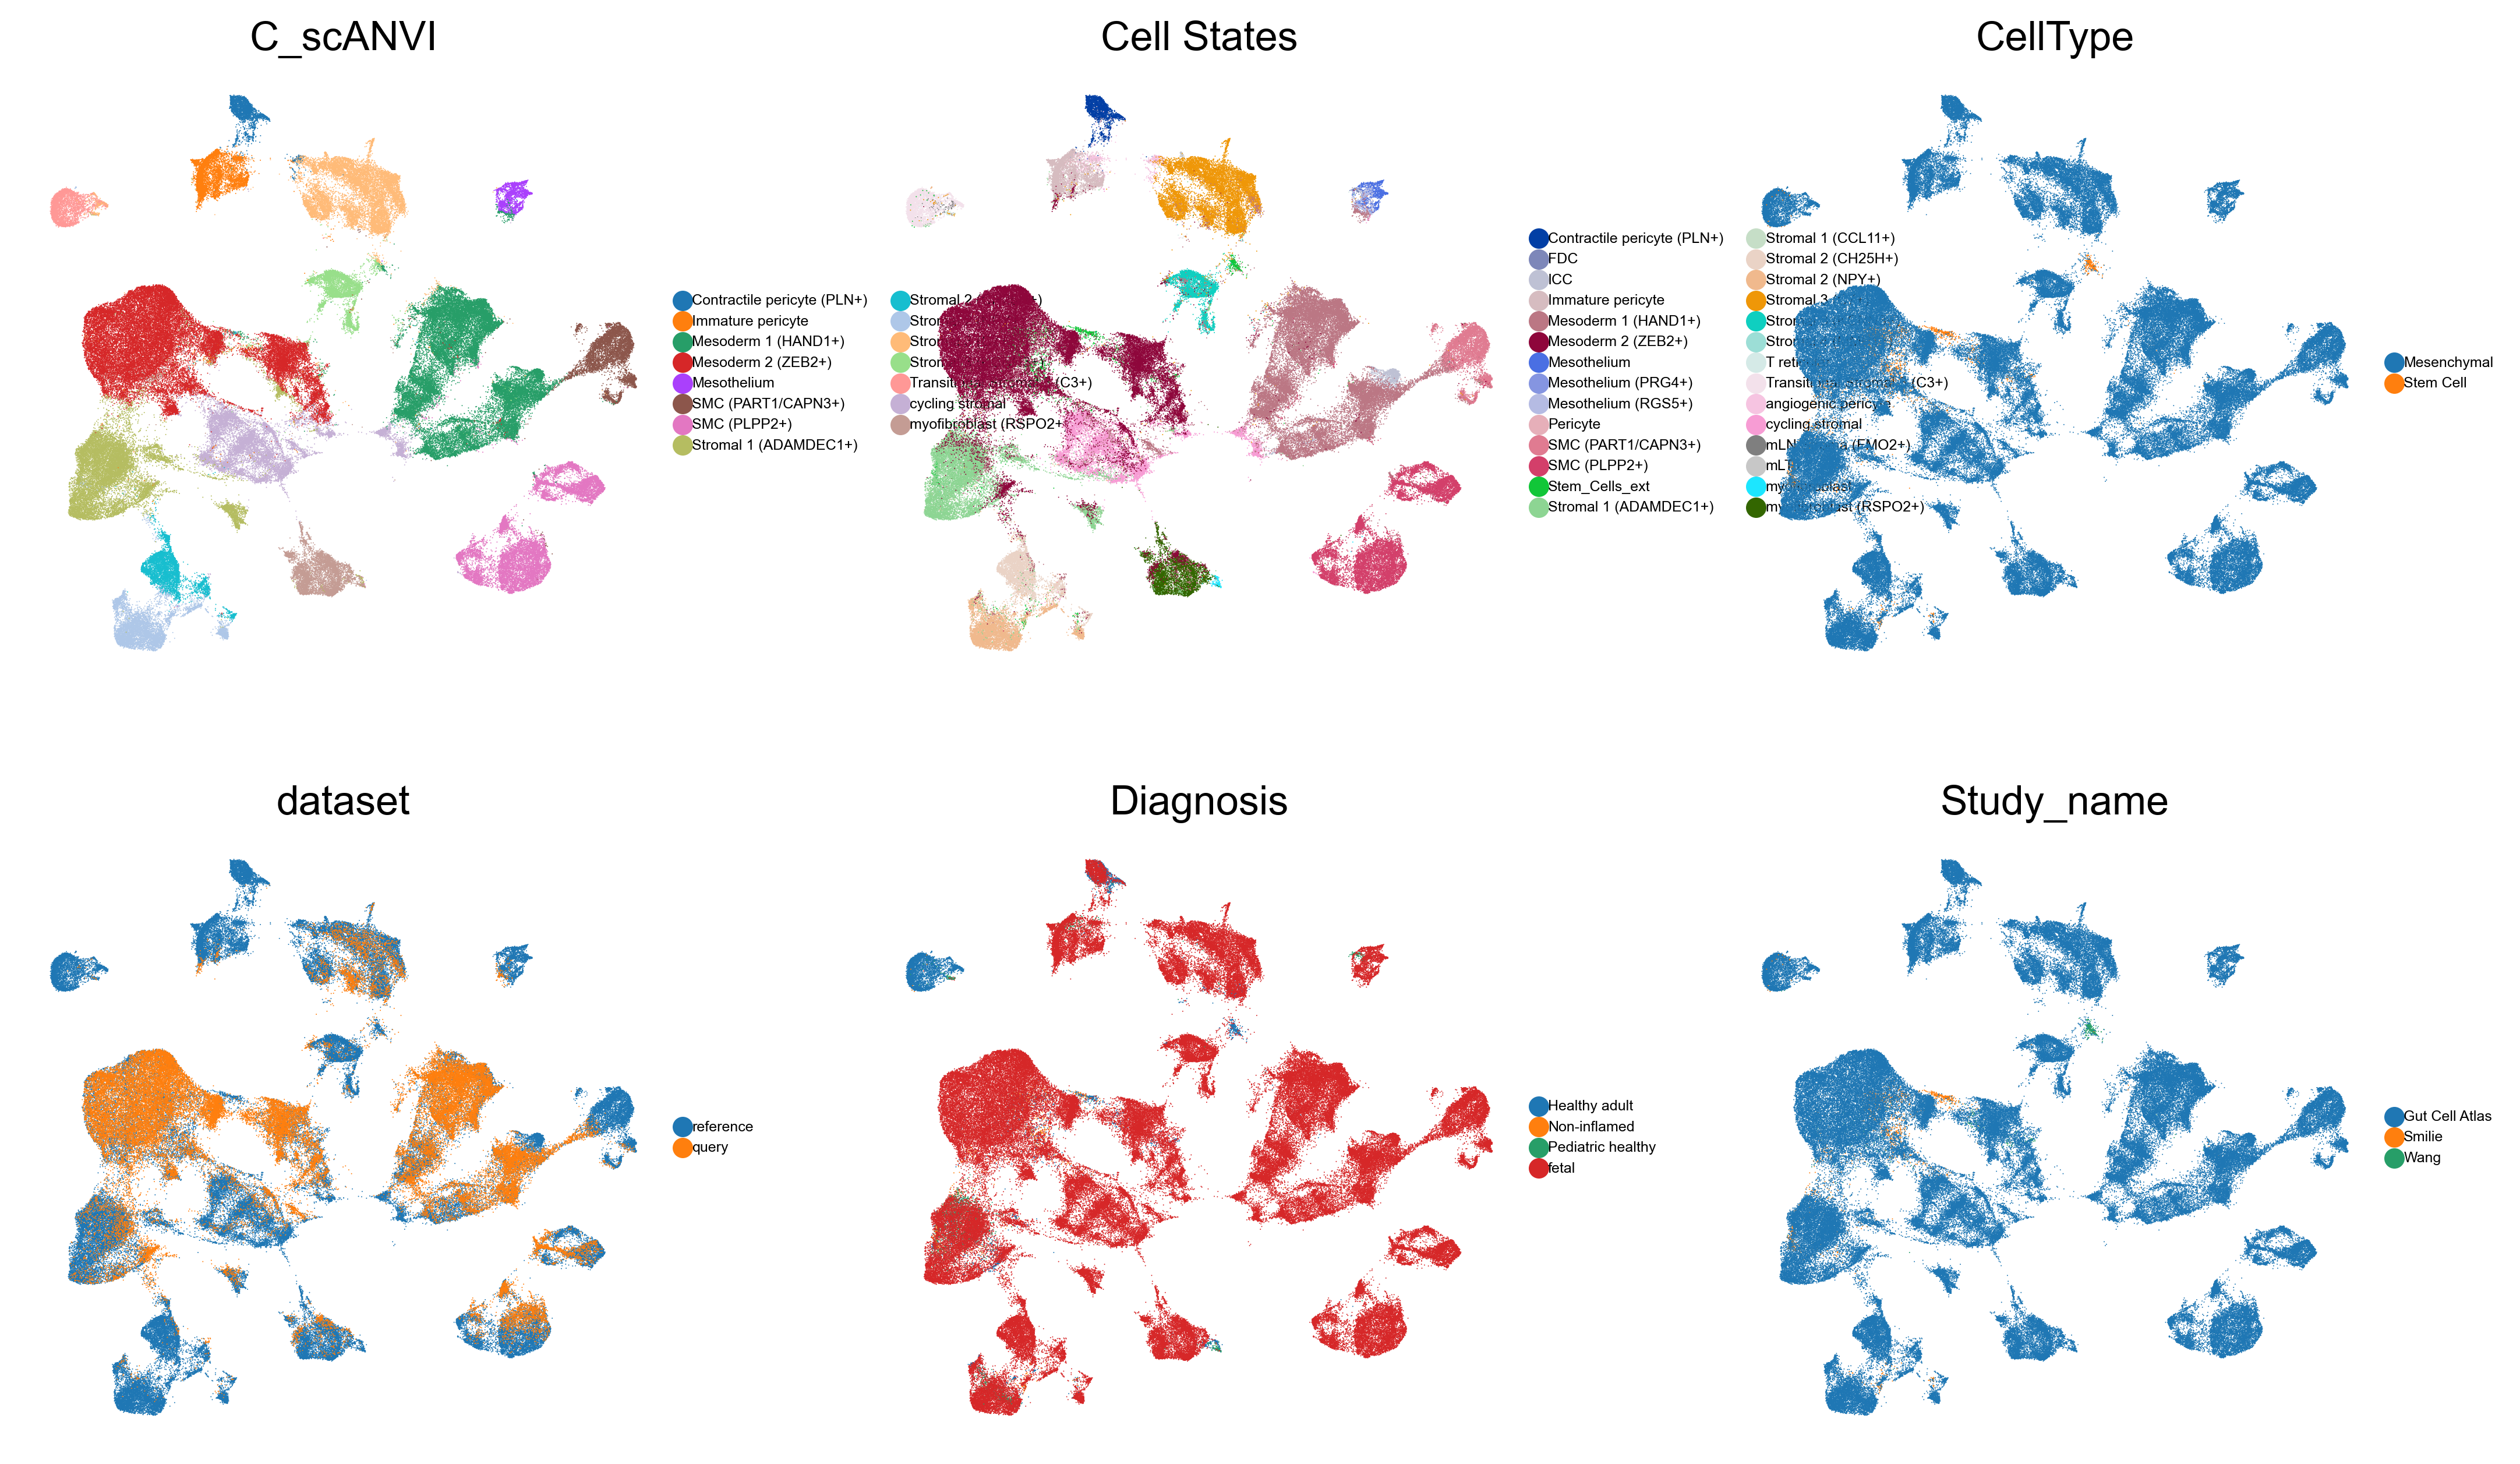

In [29]:
sc.pl.umap(adata, frameon = False, color = ['C_scANVI', 'Cell States', 'CellType', 'dataset', 'Diagnosis', 'Study_name'], size = 0.6, legend_fontsize = 5, ncols = 3)

In [ ]:
#Write anndata object to file - cluster path
adata.write_h5ad('/lustre/groups/talaveralopez/workspace/anna.maguza/Processed_datasets/expi_map/Mesenchymal_cells_after_scanvi.h5ad')

In [30]:
#Write anndata object to file - local machine path
adata.write_h5ad('/Users/anna.maguza/Desktop/Data/Processed_datasets/post_SCANVI/Mesenchymal/Mesenchymal_cells_after_scanvi2.h5ad')

### Models Validation

In [ ]:
input_file = '/lustre/groups/talaveralopez/workspace/anna.maguza/Processed_datasets/expi_map/Mesenchymal_cells_after_scanvi.h5ad'
output_file = '/lustre/groups/talaveralopez/workspace/anna.maguza/Processed_datasets/expi_map/Mesenchymal_cells_after_scanvi_output.h5ad'
adata = sc.read_h5ad(input_file)

In [31]:
adata.obs['C_scANVI'].value_counts()

Mesoderm 2 (ZEB2+)              31730
Mesoderm 1 (HAND1+)             27669
Stromal 1 (ADAMDEC1+)           15712
Stromal 3 (C7+)                 13496
SMC (PLPP2+)                    13314
cycling stromal                 10913
Stromal 2 (NPY+)                 7242
myofibroblast (RSPO2+)           6743
SMC (PART1/CAPN3+)               6346
Stromal 2 (CH25H+)               5644
Immature pericyte                5595
Stromal 3 (KCNN3+)               5056
Transitional Stromal 3 (C3+)     3786
Contractile pericyte (PLN+)      2917
Mesothelium                      2130
Name: C_scANVI, dtype: int64

In [32]:
adata.obs['Cell States'].value_counts()

Mesoderm 2 (ZEB2+)              34731
Mesoderm 1 (HAND1+)             29399
SMC (PLPP2+)                    13156
Stromal 3 (C7+)                 12412
Stromal 1 (ADAMDEC1+)           11296
cycling stromal                  8751
Stromal 2 (NPY+)                 6715
SMC (PART1/CAPN3+)               5714
myofibroblast (RSPO2+)           5634
Stromal 2 (CH25H+)               5608
Immature pericyte                4511
Stromal 3 (KCNN3+)               4402
Transitional Stromal 3 (C3+)     3636
Contractile pericyte (PLN+)      2634
Stem_Cells_ext                   2508
Stromal 1 (CCL11+)               1728
ICC                              1404
Mesothelium                      1036
angiogenic pericyte               994
Mesothelium (RGS5+)               869
Pericyte                          275
myofibroblast                     248
FDC                               177
T reticular                       158
mLN Stroma (FMO2+)                129
mLTo                              123
Mesothelium 

Text(0, 0.5, 'Observed')

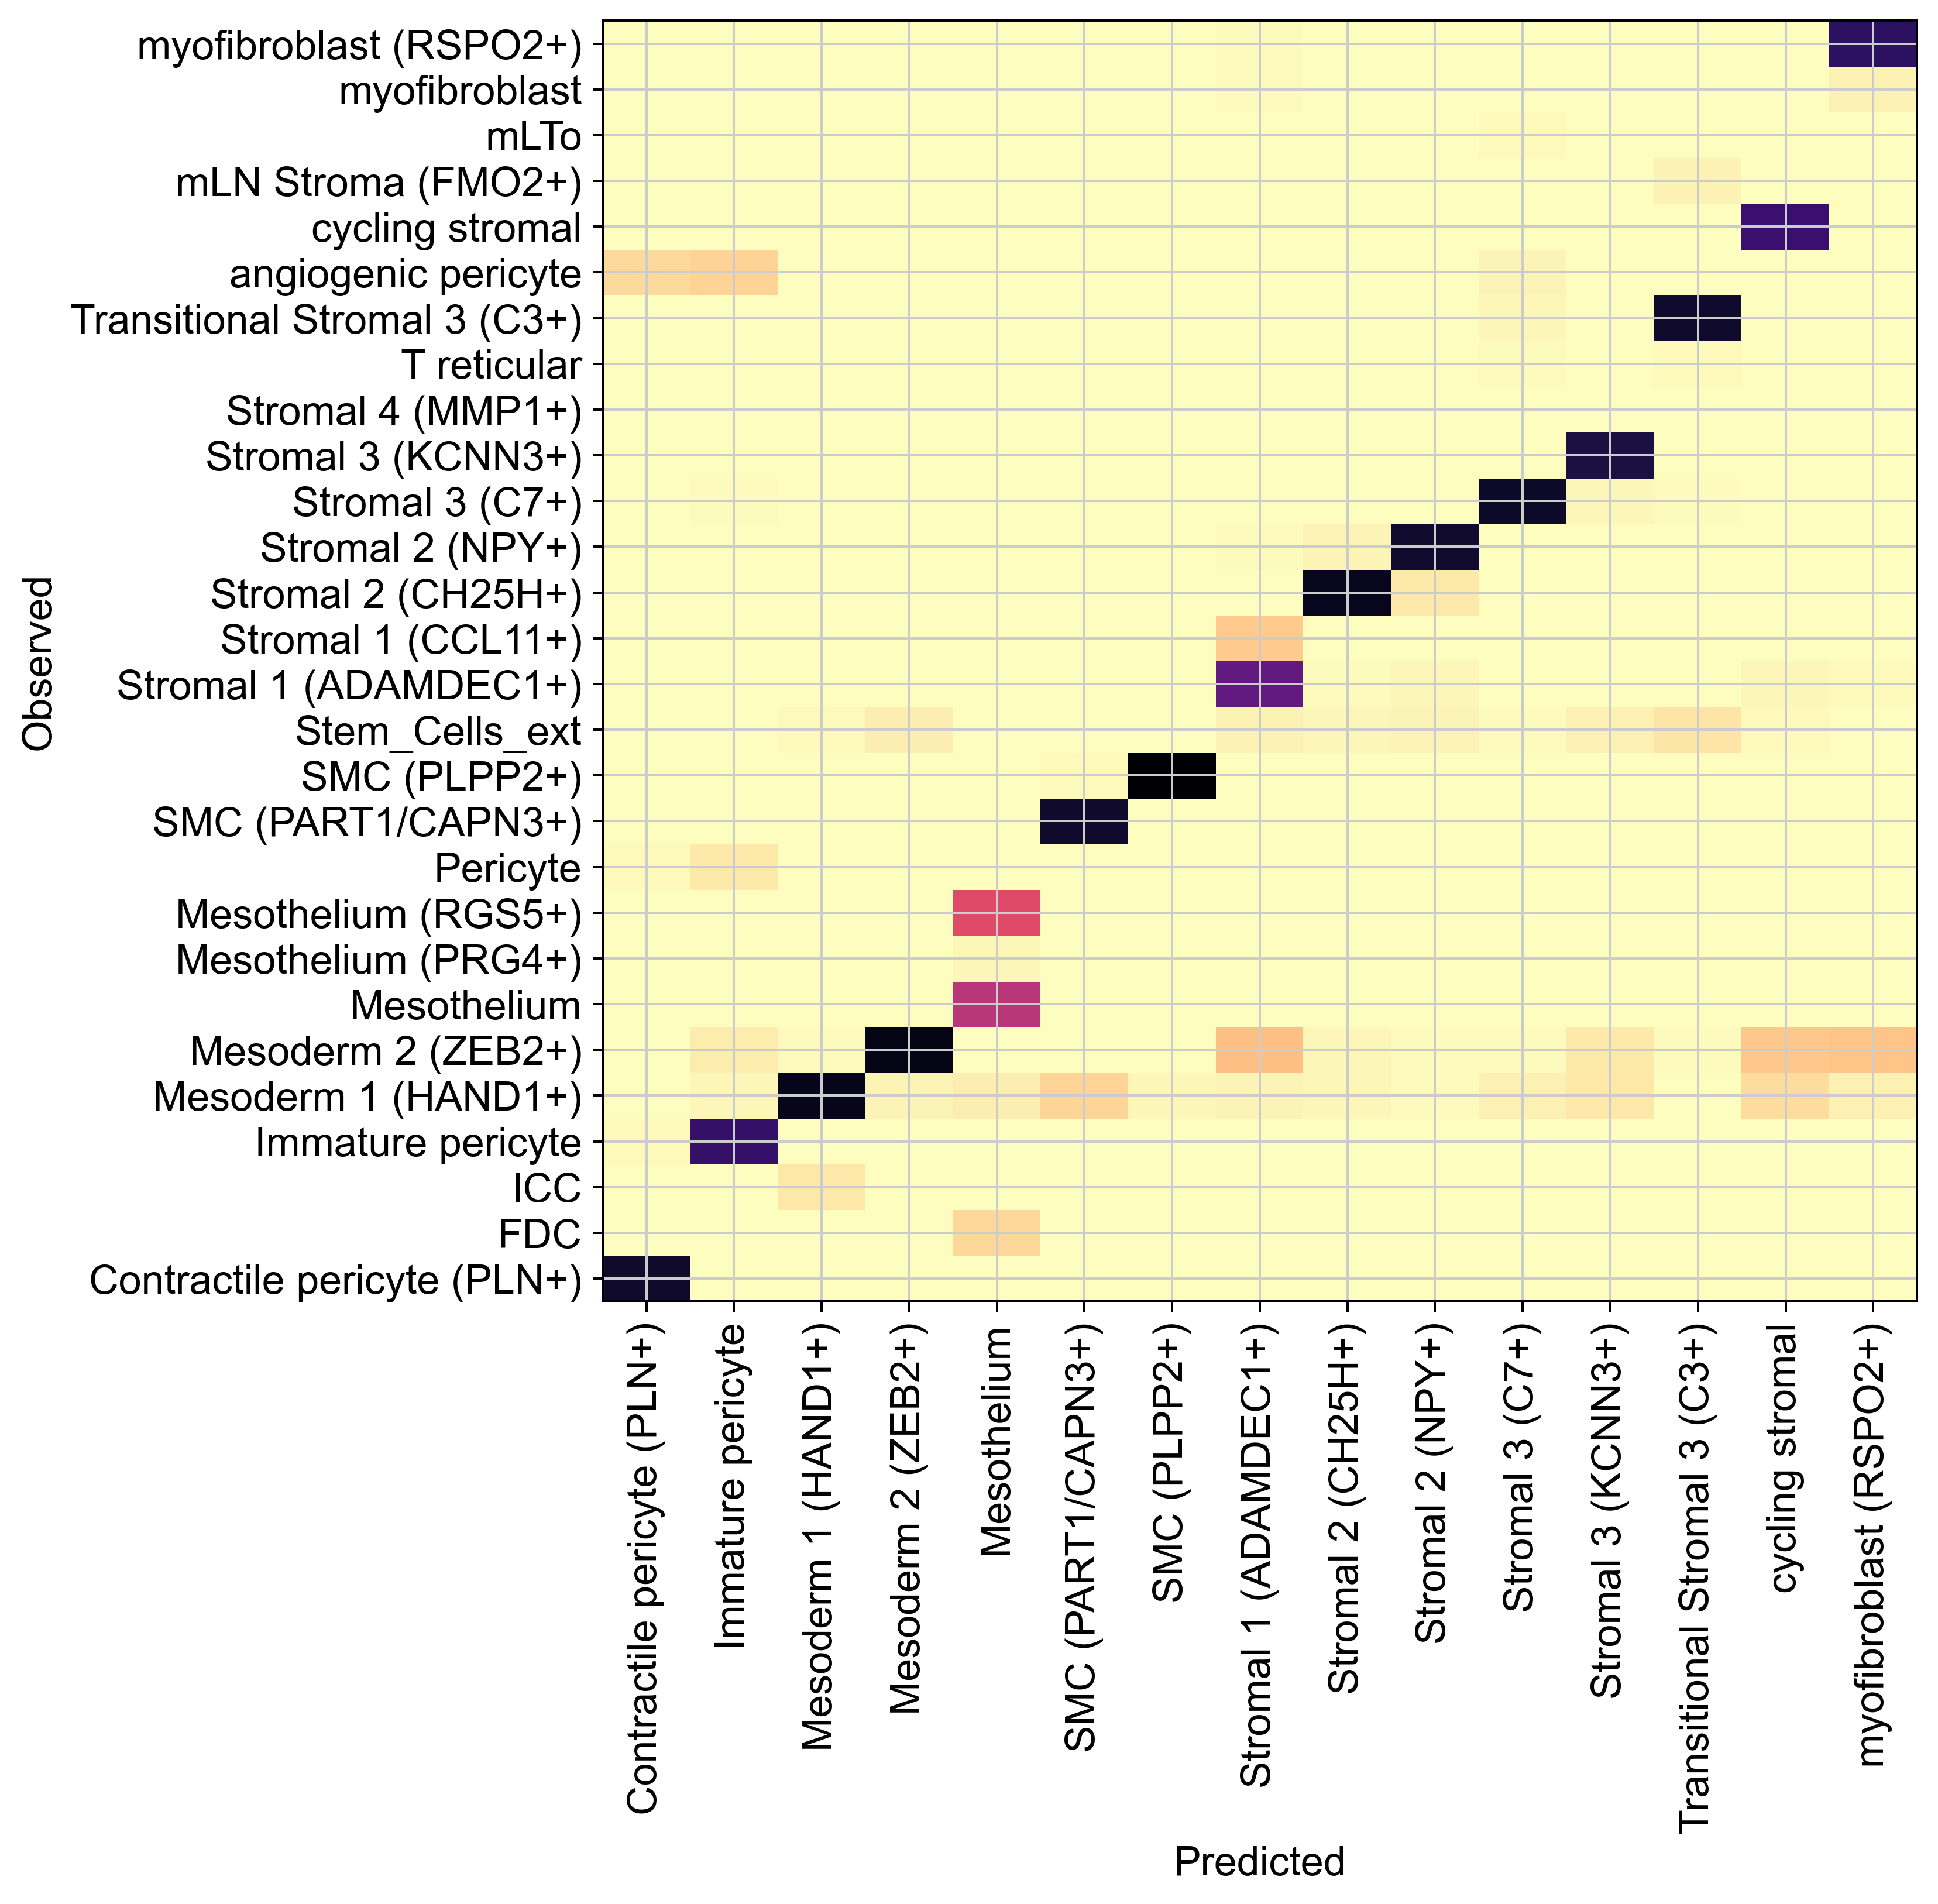

In [33]:
#Validation of the clusters
df = adata.obs.groupby(['Cell States', "C_scANVI"]).size().unstack(fill_value=0)
norm_df = df / df.sum(axis=0)

plt.figure(figsize=(8, 8))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")

In [34]:
#Calculate accuracy
print(f"Acc: {np.mean(adata.obs.CellType.cat.codes == adata.obs.C_scANVI.cat.codes)}")

Acc: 0.018459439141339164
